In [1]:
# standard library imports
import pandas as pd
import numpy as np
import warnings
import sys
#import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

# third party imports

# suppress warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# graph output
%matplotlib inline

In [2]:
import os

os.chdir('E:/BikeShareResearch/ALL')

In [5]:
# read in the csv data files

def getdata_csv(file):
    '''
    Args:
        csv file name
    Output:
        dataframe of the csv data
    '''

    outdf = pd.read_csv(file)
    return outdf

# read station data
station = getdata_csv('E:/BikeShareResearch/ALL/Station.csv')

# read quarterly trip data
quarter1 = getdata_csv('E:/BikeShareResearch/ALL/metro-bike-share-trips-2018-q1.csv')
quarter2 = getdata_csv('E:/BikeShareResearch/ALL/metro-bike-share-trips-2018-q2.csv')
quarter3 = getdata_csv('E:/BikeShareResearch/ALL/metro-bike-share-trips-2018-q3.csv')
quarter4 = getdata_csv('E:/BikeShareResearch/ALL/metro-bike-share-trips-2018-q4.csv')
quarter5 = getdata_csv('E:/BikeShareResearch/ALL/metro-bike-share-trips-2019-q1.csv')

# concatenate the quarterly trip data into one dataframe
trip = quarter5.append(quarter4, ignore_index=True, sort=False) \
.append(quarter3, ignore_index=True, sort=False) \
.append(quarter2, ignore_index=True, sort=False) \
.append(quarter1, ignore_index=True, sort=False)

In [6]:
station.head()

,Station_ID,Station_Name,Go_live_date,Region,Status
0,3000,Virtual Station,7/7/2016,NaN,Active
1,3005,7th & Flower,7/7/2016,DTLA,Active
2,3006,Olive & 8th,7/7/2016,DTLA,Active
3,3007,5th & Grand,7/7/2016,DTLA,Active
4,3008,Figueroa & 9th,7/7/2016,DTLA,Active


In [7]:
# check the combined trip data
trip.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,06468,1,One Way,Walk-up,standard
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,12311,1,One Way,Walk-up,standard
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,05992,1,One Way,Walk-up,standard
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,05860,1,One Way,Walk-up,standard
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,06006,1,One Way,Walk-up,standard


In [8]:
# unnecessary columns from station data
columns = ['Station_ID','Station_Name','Go_live_date']

# add start station info
result = pd.merge(trip,
                  station,
                  left_on = 'start_station', 
                  right_on = 'Station_ID',
                  how='left').rename(index=str, columns={'Region ': 'start_region', 'Status': 'start_status'})

# remove unnecessary columns of station data
result.drop(columns, inplace=True, axis=1)

# add end station info
result = pd.merge(result,
                  station,
                  left_on = 'end_station', 
                  right_on = 'Station_ID',
                  how='left').rename(index=str, columns={'Region ': 'end_region', 'Status': 'end_status'})

# remove unnecessary columns of station data
result.drop(columns, inplace=True, axis=1)

# final result of combined station and trip data
result.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,Region_x,start_status,Region_y,end_status
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,06468,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,12311,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,05992,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,05860,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,06006,1,One Way,Walk-up,standard,DTLA,Active,DTLA,Active


In [9]:
# load the LA weather data
weather = getdata_csv('E:/BikeShareResearch/ALL/LATemp.csv')

# check the first five rows of the weather data
weather.head()

,Unnamed: 0,DATE,TMIN,TAVG,TMAX
0,731,2018-01-01,48.535714,58.910714,70.392857
1,732,2018-01-02,53.321429,64.000000,76.357143
2,733,2018-01-03,54.000000,63.035714,72.142857
3,734,2018-01-04,52.785714,62.250000,73.500000
4,735,2018-01-05,52.857143,61.535714,71.607143


In [10]:
# drop unnecessary columns
weather = weather.drop(columns=['Unnamed: 0'])

# standerdize the column names
weather = weather.rename(columns={'DATE': 'date', 'TMIN': 'tmin', 'TAVG': 'tavg', 'TMAX': 'tmax'})

# Checking the data types for the result data frame
result.dtypes

trip_id                  int64
duration                 int64
start_time              object
end_time                object
start_station            int64
start_lat              float64
start_lon              float64
end_station              int64
end_lat                float64
end_lon                float64
bike_id                 object
plan_duration            int64
trip_route_category     object
passholder_type         object
bike_type               object
Region_x                object
start_status            object
Region_y                object
end_status              object
dtype: object

In [11]:
# convert the start_time and end_time into date object
result['start_time'] = pd.to_datetime(result['start_time'])
result['end_time'] = pd.to_datetime(result['end_time'])

# check the data types to make sure its converted into date time object
result.dtypes

trip_id                         int64
duration                        int64
start_time             datetime64[ns]
end_time               datetime64[ns]
start_station                   int64
start_lat                     float64
start_lon                     float64
end_station                     int64
end_lat                       float64
end_lon                       float64
bike_id                        object
plan_duration                   int64
trip_route_category            object
passholder_type                object
bike_type                      object
Region_x                       object
start_status                   object
Region_y                       object
end_status                     object
dtype: object

In [12]:
# converting the date in the weather data frame to datetime object
weather['date'] = pd.to_datetime(weather['date'])

# checking to make sure the date is in date time object
weather.dtypes

date    datetime64[ns]
tmin           float64
tavg           float64
tmax           float64
dtype: object

In [13]:
# filter the weather data frame to contain the values only upto the firts quarter of the year 2019
weather_to2019Q1 = weather[weather['date'] <= '2019-03-31']

# check the head of the Date column in weather
print('Head:') 
print(weather_to2019Q1.sort_values(by ='date').date.head())

# check the tail of the Date column in weather
print('Tail:') 
print(weather_to2019Q1.sort_values(by ='date').date.tail())

Head:
0   2018-01-01
1   2018-01-02
2   2018-01-03
3   2018-01-04
4   2018-01-05
Name: date, dtype: datetime64[ns]
Tail:
450   2019-03-27
451   2019-03-28
452   2019-03-29
453   2019-03-30
454   2019-03-31
Name: date, dtype: datetime64[ns]


In [14]:
# extract the date from the date time object and creating a DATE column 
result['date'] = pd.to_datetime(result['start_time']).dt.date

# check the head of the Date column in result
result.sort_values(by = 'date').date.head()

304639    2018-01-01
304379    2018-01-01
304380    2018-01-01
304381    2018-01-01
304382    2018-01-01
Name: date, dtype: object

In [15]:

# check the head of the Date column in result
result.sort_values(by = 'date').date.tail()

56996    2019-03-31
56997    2019-03-31
56998    2019-03-31
56992    2019-03-31
56841    2019-03-31
Name: date, dtype: object

In [16]:
result['date'] = pd.to_datetime(result['date'])

# since the two data frames have the same column 'DATE', we will join the data frame by DATE
trip_merged = pd.merge(result, weather_to2019Q1)

# Check the head of the top five rows of the combined data frame
trip_merged[['trip_id','date','tmin', 'tavg', 'tmax']].head()

,trip_id,date,tmin,tavg,tmax
0,112536773,2019-01-01,39.888889,47.851852,55.740741
1,112536772,2019-01-01,39.888889,47.851852,55.740741
2,112538689,2019-01-01,39.888889,47.851852,55.740741
3,112538688,2019-01-01,39.888889,47.851852,55.740741
4,112538687,2019-01-01,39.888889,47.851852,55.740741


In [17]:
# check the tail of the last five rows of the combined data frame
trip_merged[['trip_id','date','tmin', 'tavg', 'tmax']].tail()

,trip_id,date,tmin,tavg,tmax
369247,79626925,2018-03-31,52.428571,61.892857,72.428571
369248,79626924,2018-03-31,52.428571,61.892857,72.428571
369249,79626923,2018-03-31,52.428571,61.892857,72.428571
369250,79626922,2018-03-31,52.428571,61.892857,72.428571
369251,79626921,2018-03-31,52.428571,61.892857,72.428571


In [18]:
# checkpoint - the analysis could be resumed from here
# write the final dataset to a csv file for future load
trip_merged.to_csv('E:/BikeShareResearch/ALL/Bikesharing-Weather-Combined.csv')
#We faced two roadblocks while integrating the wethaer data.
#Weather data was not at the same grain with station location in terms of zip code.
#Zip code level weather data is available but we could not find zip code level trip data.
##Resolution: We took average of the daily meteorological attributes and applied to the trip data.

In [19]:
trip_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369252 entries, 0 to 369251
Data columns (total 23 columns):
trip_id                369252 non-null int64
duration               369252 non-null int64
start_time             369252 non-null datetime64[ns]
end_time               369252 non-null datetime64[ns]
start_station          369252 non-null int64
start_lat              367976 non-null float64
start_lon              367976 non-null float64
end_station            369252 non-null int64
end_lat                362698 non-null float64
end_lon                362698 non-null float64
bike_id                369252 non-null object
plan_duration          369252 non-null int64
trip_route_category    369252 non-null object
passholder_type        369252 non-null object
bike_type              131225 non-null object
Region_x               368247 non-null object
start_status           369197 non-null object
Region_y               363120 non-null object
end_status             369204 non-null object


In [20]:
trip_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369252 entries, 0 to 369251
Data columns (total 23 columns):
trip_id                369252 non-null int64
duration               369252 non-null int64
start_time             369252 non-null datetime64[ns]
end_time               369252 non-null datetime64[ns]
start_station          369252 non-null int64
start_lat              367976 non-null float64
start_lon              367976 non-null float64
end_station            369252 non-null int64
end_lat                362698 non-null float64
end_lon                362698 non-null float64
bike_id                369252 non-null object
plan_duration          369252 non-null int64
trip_route_category    369252 non-null object
passholder_type        369252 non-null object
bike_type              131225 non-null object
Region_x               368247 non-null object
start_status           369197 non-null object
Region_y               363120 non-null object
end_status             369204 non-null object


In [21]:
round(trip_merged.describe(),2)

,trip_id,duration,start_station,start_lat,start_lon,end_station,end_lat,end_lon,plan_duration,tmin,tavg,tmax
count,3.692520e+05,369252.00,369252.00,367976.00,367976.00,369252.00,362698.00,362698.00,369252.00,369252.00,369252.00,369252.00
mean,9.731025e+07,40.12,3387.71,34.04,-118.29,3383.35,34.04,-118.29,31.05,55.26,64.53,74.78
std,1.505842e+07,132.47,532.86,0.06,0.10,531.97,0.06,0.10,70.53,8.35,9.00,10.24
min,6.540635e+07,1.00,3000.00,33.71,-118.49,3000.00,33.71,-118.49,0.00,36.32,44.52,52.37
25%,8.502398e+07,7.00,3030.00,34.04,-118.27,3030.00,34.04,-118.27,1.00,49.25,58.14,67.07
50%,1.025874e+08,13.00,3058.00,34.05,-118.25,3055.00,34.05,-118.25,30.00,54.50,63.96,74.79
75%,1.092788e+08,28.00,4157.00,34.05,-118.24,4157.00,34.05,-118.24,30.00,61.27,71.71,82.61
max,1.188434e+08,1440.00,4385.00,34.17,-118.12,4382.00,34.17,-118.12,999.00,77.19,89.56,106.74


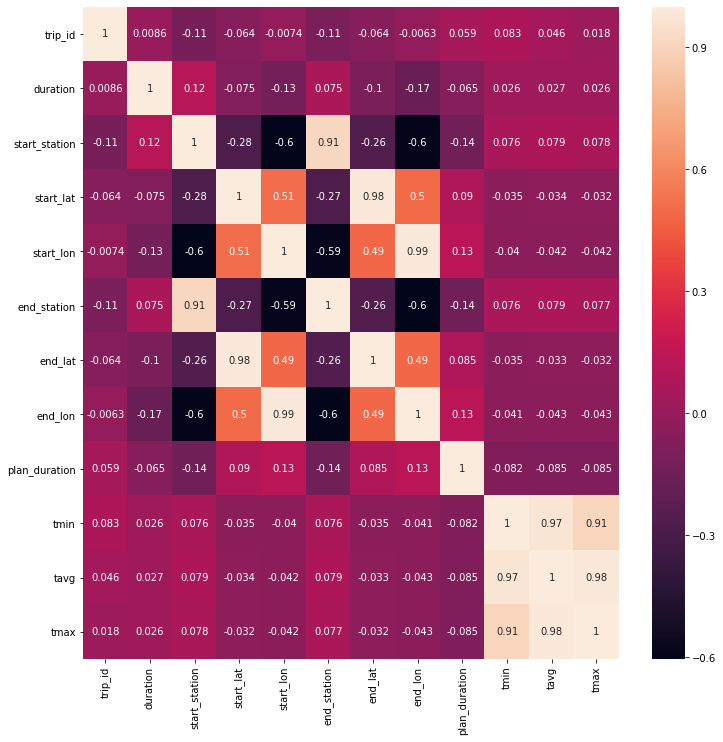

In [24]:

plt.figure(figsize = (12,12))
# Correlation Matrix
sns.heatmap(trip_merged \
            .drop(columns=['passholder_type','bike_type','Region_x','start_status','Region_y','end_status']) \
            .corr(), annot=True)

# since we need to correlation graph a bit larger for easy interpretation, change the output size
plt.rcParams["figure.figsize"] = (12,12)

plt.show()

In [25]:
trip_merged.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'Region_x', 'start_status', 'Region_y', 'end_status',
       'date', 'tmin', 'tavg', 'tmax'],
      dtype='object')

In [26]:
countsbypasstype = trip_merged.groupby(['passholder_type']).trip_id.count().reset_index(name='counts')
countsbypasstype.columns

Index(['passholder_type', 'counts'], dtype='object')

In [27]:
countsbypasstype

,passholder_type,counts
0,Annual Pass,5876
1,Flex Pass,7021
2,Monthly Pass,190987
3,One Day Pass,20108
4,Testing,11
5,Walk-up,145249


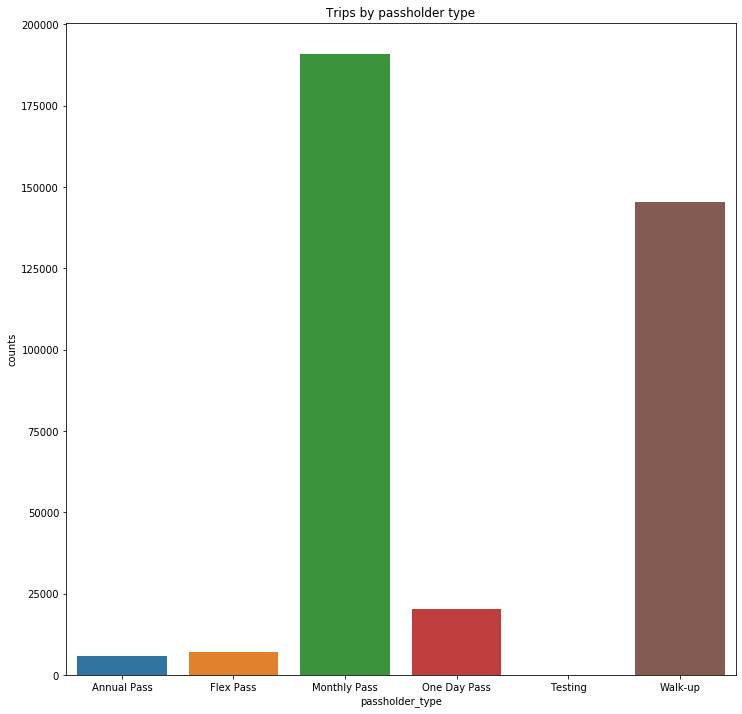

In [28]:
#plot the bar chart

# plot the graph
p = sns.barplot('passholder_type', 'counts', data = countsbypasstype)
plt.Figure(figsize=(8,8))
plt.title("Trips by passholder type")

plt.show(p)

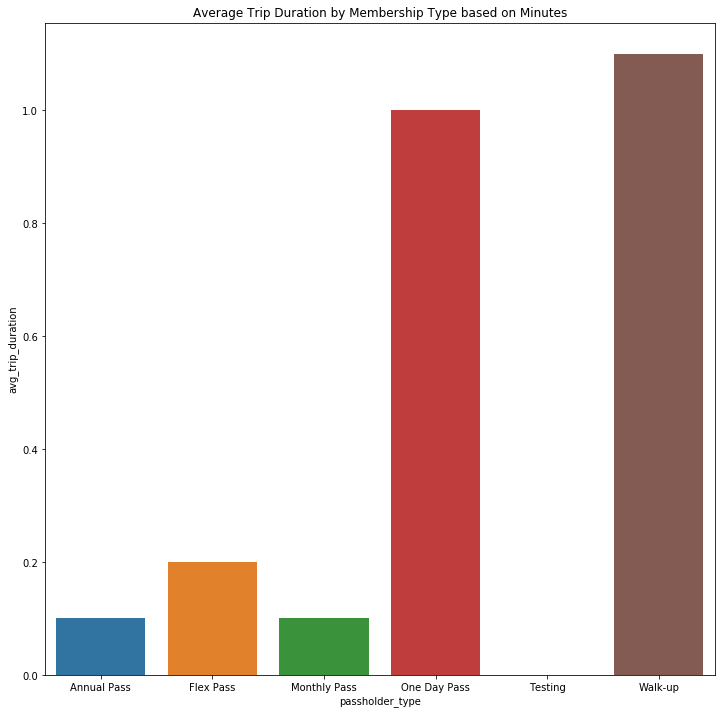

In [29]:
# add minutes column for trip duration
trip_merged['minutes'] = round(trip_merged['duration']/60).astype(int)

# calculate trip duration based on minutes
avg_dur_membership = pd.DataFrame()
avg_dur_membership['avg_trip_duration'] = round(trip_merged.groupby('passholder_type')['minutes'].mean(),1)
avg_dur_membership = avg_dur_membership.reset_index()
avg_dur_membership['passholder_type'] = avg_dur_membership['passholder_type'].astype('object')

# plot the graph
g = sns.barplot('passholder_type', 'avg_trip_duration', data = avg_dur_membership)
plt.Figure(figsize=(20,20))
plt.title("Average Trip Duration by Membership Type based on Minutes")

plt.show(g)

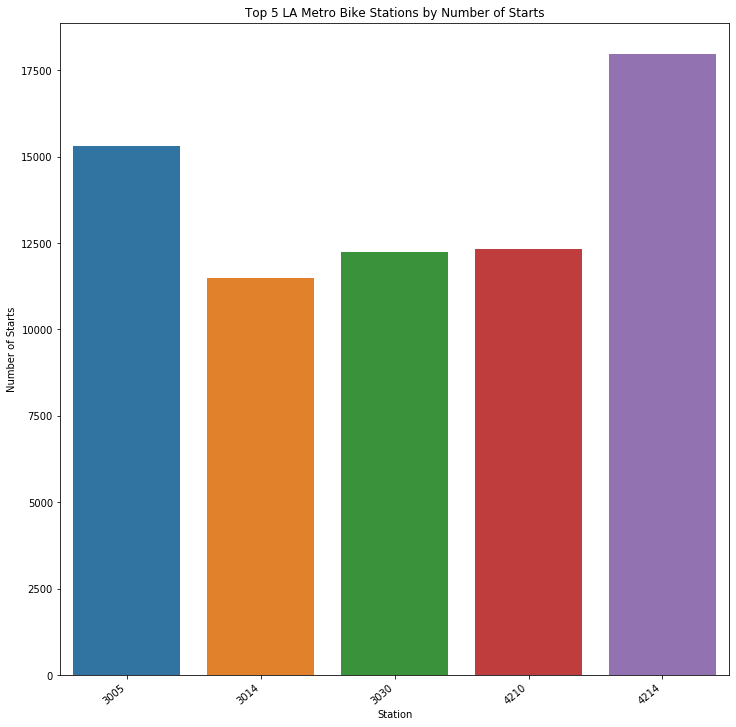

In [30]:

# data for Top 5 Stations visual
top5 = pd.DataFrame()
top5['Station'] = trip_merged['start_station'].value_counts().head().index
top5['Number of Starts']=trip_merged['start_station'].value_counts().head().values
top5['Station'] = top5['Station'].astype('category')
top5['Station'] = top5.Station.cat.remove_unused_categories()

# plot the top 5 stations
sns.barplot('Station', 'Number of Starts', data = top5)
plt.xticks(rotation=40, ha = 'right')
plt.title("Top 5 LA Metro Bike Stations by Number of Starts")
plt.show()

In [32]:
# get active stations
station_act = pd.DataFrame()
station_act = station[station.Status == 'Active'][['Station_ID']] \
.rename(index=str, columns={'Station_ID': 'station_id'})

# add the lat-long from trip data
# first try the start stations
start_geo = trip_merged[['start_station','start_lat','start_lon']] \
.rename(index=str, columns={'start_station': 'station_id', 'start_lat': 'lat', 'start_lon': 'lon'})

end_geo = trip_merged[['end_station','end_lat','end_lon']] \
.rename(index=str, columns={'end_station': 'station_id', 'end_lat': 'lat', 'end_lon': 'lon'})

station_geo = start_geo.append(end_geo).drop_duplicates().dropna()

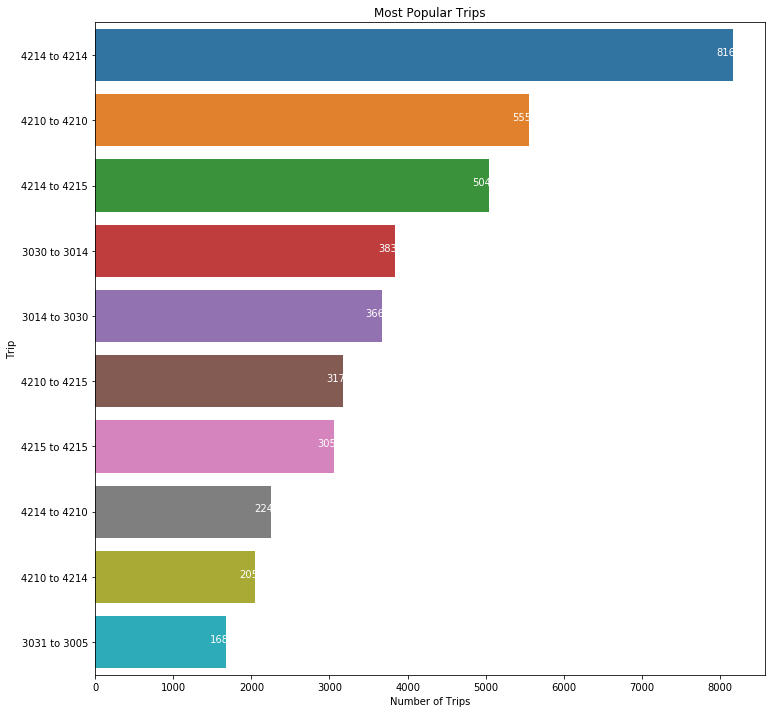

In [33]:
# calculate the number of trips between each stations
trips_df = pd.DataFrame()
trips_df = trip_merged.groupby(['start_station','end_station']).size().reset_index(name = 'Number of Trips')
trips_df = trips_df.sort_values('Number of Trips', ascending = False)
trips_df['Starting Station ID'] = trips_df['start_station'].astype('str')
trips_df['Ending Station ID'] = trips_df['end_station'].astype('str')
trips_df['Trip'] = trips_df['Starting Station ID'] + ' to ' + trips_df['Ending Station ID']
trips_df = trips_df[:10]
trips_df = trips_df.drop(['Starting Station ID', 'Ending Station ID'], axis = 1)
trips_df = trips_df.reset_index()

# find the most popular trips
g = sns.barplot('Number of Trips','Trip', data = trips_df)
plt.title("Most Popular Trips")
for index, row in trips_df.iterrows():
    g.text(row['Number of Trips']-50,index,row['Number of Trips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

In [34]:
countbydates = trip_merged.groupby(['date']).trip_id.count().reset_index(name='counts')
countbydates.head()

,date,counts
0,2018-01-01,781
1,2018-01-02,765
2,2018-01-03,717
3,2018-01-04,736
4,2018-01-05,742


Text(0.5, 1.0, 'Trips throughout the year - Trend analysis')

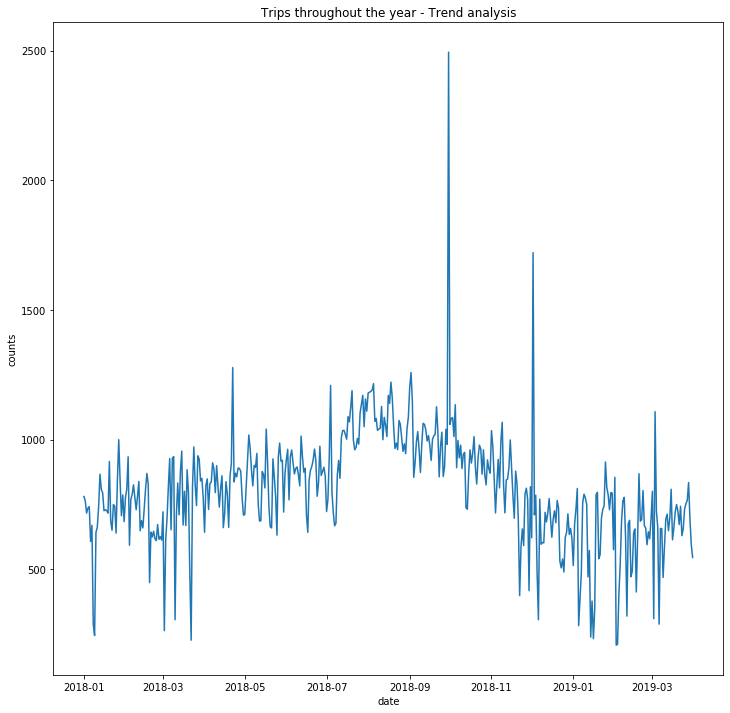

In [35]:
sns.lineplot(x="date", y="counts",
                data=countbydates)

plt.title("Trips throughout the year - Trend analysis")

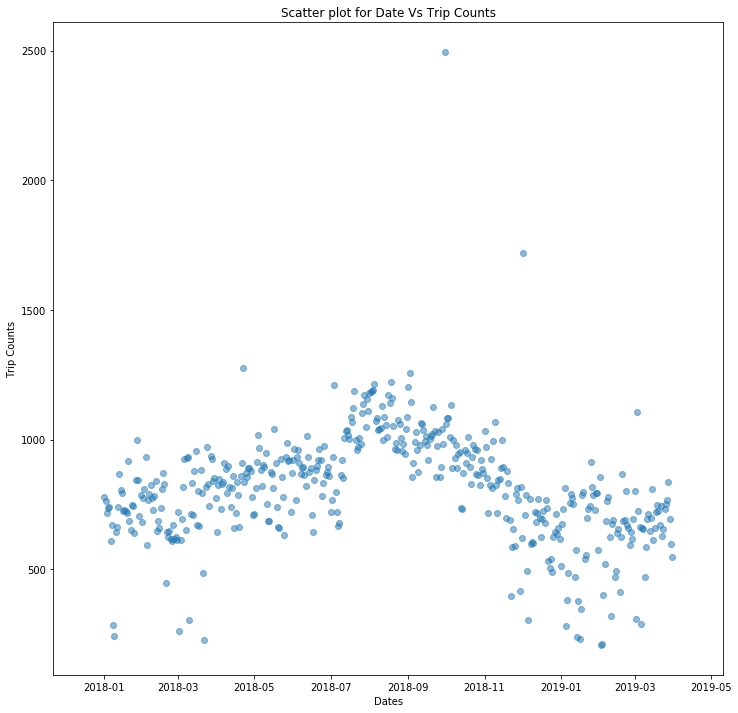

In [36]:
# Plot
plt.scatter(countbydates.date, countbydates.counts,alpha=0.5)
plt.title('Scatter plot for Date Vs Trip Counts')
plt.xlabel('Dates')
plt.ylabel('Trip Counts')
plt.show()

In [37]:

trip_merged.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'Region_x', 'start_status', 'Region_y', 'end_status',
       'date', 'tmin', 'tavg', 'tmax', 'minutes'],
      dtype='object')

In [38]:
# derving 'day of week' attribute from date
trip_merged['day_of_week'] = trip_merged['date'].dt.day_name()
trip_merged.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,Region_x,start_status,Region_y,end_status,date,tmin,tavg,tmax,minutes,day_of_week
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,1,Tuesday
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday


In [39]:
# summarizing trips with dates and day of weeks
countbywkday = trip_merged.groupby(['date', 'day_of_week']).trip_id.count().reset_index(name='counts')
countbywkday.head()

,date,day_of_week,counts
0,2018-01-01,Monday,781
1,2018-01-02,Tuesday,765
2,2018-01-03,Wednesday,717
3,2018-01-04,Thursday,736
4,2018-01-05,Friday,742


(736664.0, 737180.0)

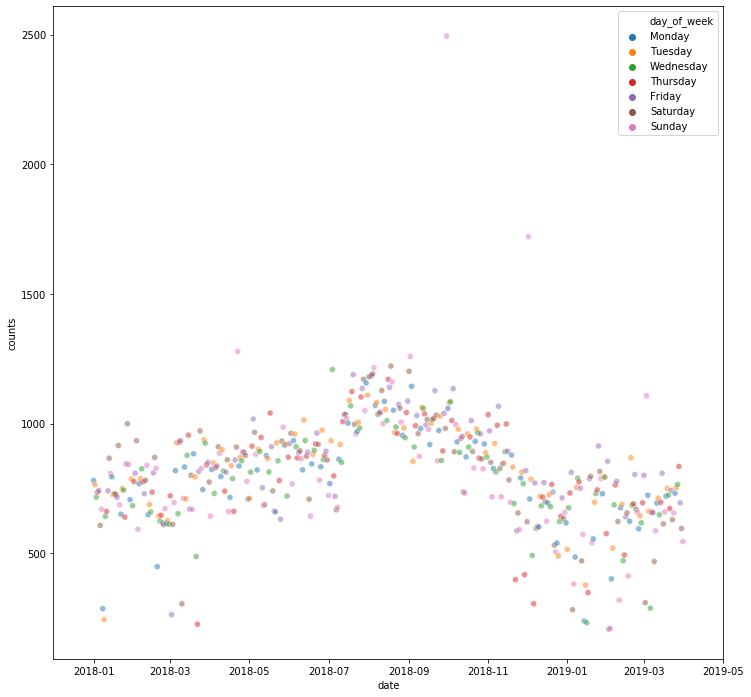

In [40]:

sns.scatterplot(x = countbywkday.date,y = countbywkday.counts, hue = countbywkday.day_of_week, alpha=0.5)

# control x and y limits
plt.xlim('2017-12-01', '2019-05-01')

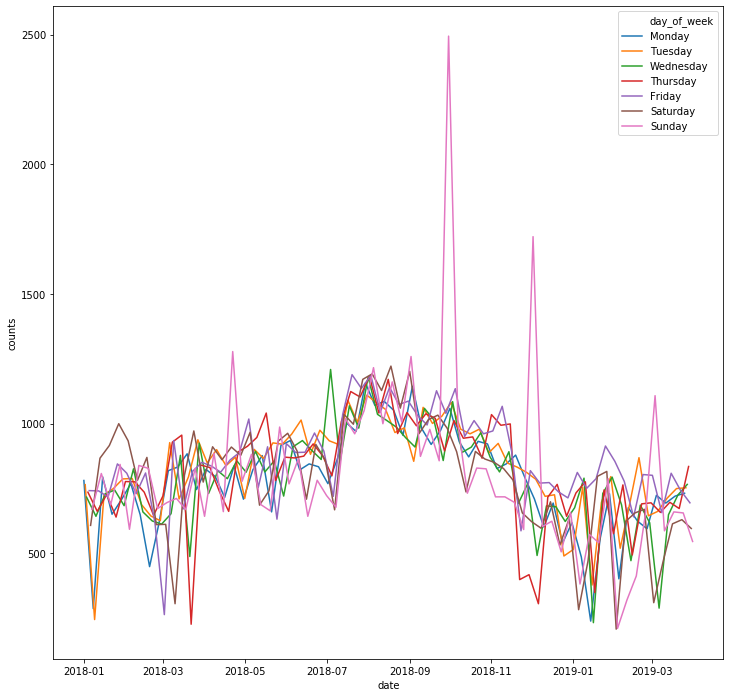

In [41]:
sns.lineplot(x = countbywkday.date,y = countbywkday.counts, hue = countbywkday.day_of_week)

In [42]:
pd.get_dummies(trip_merged)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,Region_y_Westside,end_status_Active,end_status_Inactive,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.247490,3051,34.045422,-118.253517,...,0,1,0,0,0,0,0,0,1,0
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.247490,3051,34.045422,-118.253517,...,0,1,0,0,0,0,0,0,1,0
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
5,112538686,28,2019-01-01 00:23:00,2019-01-01 00:51:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
6,112538685,27,2019-01-01 00:24:00,2019-01-01 00:51:00,3030,34.051941,-118.243530,3075,34.042110,-118.256187,...,0,1,0,0,0,0,0,0,1,0
7,112537730,7,2019-01-01 00:27:00,2019-01-01 00:34:00,3029,34.048851,-118.246422,3038,34.046822,-118.248352,...,0,1,0,0,0,0,0,0,1,0
8,112538445,19,2019-01-01 00:27:00,2019-01-01 00:46:00,3030,34.051941,-118.243530,3031,34.044701,-118.252441,...,0,1,0,0,0,0,0,0,1,0
9,112537729,6,2019-01-01 00:28:00,2019-01-01 00:34:00,3029,34.048851,-118.246422,3038,34.046822,-118.248352,...,0,1,0,0,0,0,0,0,1,0


In [43]:
trip_merged.shape

(369252, 25)

In [44]:
trip_merged.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_station',
       'start_lat', 'start_lon', 'end_station', 'end_lat', 'end_lon',
       'bike_id', 'plan_duration', 'trip_route_category', 'passholder_type',
       'bike_type', 'Region_x', 'start_status', 'Region_y', 'end_status',
       'date', 'tmin', 'tavg', 'tmax', 'minutes', 'day_of_week'],
      dtype='object')

In [45]:
trip_merged.shape

(369252, 25)

In [46]:
trip_merged.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,...,Region_x,start_status,Region_y,end_status,date,tmin,tavg,tmax,minutes,day_of_week
0,112536773,7,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
1,112536772,6,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,34.052872,-118.24749,3051,34.045422,-118.253517,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
2,112538689,32,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,1,Tuesday
3,112538688,30,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday
4,112538687,28,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,34.051941,-118.24353,3075,34.042110,-118.256187,...,DTLA,Active,DTLA,Active,2019-01-01,39.888889,47.851852,55.740741,0,Tuesday


In [47]:
outstation_df = pd.DataFrame()
outstation_df['Station'] = trip_merged['start_station'].value_counts().head().index
outstation_df['Number of Starts']=trip_merged['start_station'].value_counts().head().values

In [48]:
outstation_df.head()

,Station,Number of Starts
0,4214,17978
1,3005,15317
2,4210,12329
3,3030,12240
4,3014,11484


In [49]:
outstation_df = pd.DataFrame()
outstation_df = trip_merged.groupby(['start_station', 'date','day_of_week'])['trip_id'].count().reset_index()
outstation_df.rename(columns = {'trip_id': 'outgoingbikes'}, inplace = True)
outstation_df.head()

,start_station,date,day_of_week,outgoingbikes
0,3000,2018-01-01,Monday,2
1,3000,2018-01-03,Wednesday,1
2,3000,2018-01-11,Thursday,1
3,3000,2018-01-13,Saturday,1
4,3000,2018-01-14,Sunday,4


In [50]:
instation_df = pd.DataFrame()
instation_df = trip_merged.groupby(['end_station', 'date','day_of_week'])['trip_id'].count().reset_index()
instation_df.rename(columns = {'trip_id': 'incomingbikes'}, inplace = True)
instation_df.head()

,end_station,date,day_of_week,incomingbikes
0,3000,2018-01-01,Monday,24
1,3000,2018-01-02,Tuesday,10
2,3000,2018-01-03,Wednesday,15
3,3000,2018-01-04,Thursday,13
4,3000,2018-01-05,Friday,10


In [51]:
station.columns
station.head()

,Station_ID,Station_Name,Go_live_date,Region,Status
0,3000,Virtual Station,7/7/2016,NaN,Active
1,3005,7th & Flower,7/7/2016,DTLA,Active
2,3006,Olive & 8th,7/7/2016,DTLA,Active
3,3007,5th & Grand,7/7/2016,DTLA,Active
4,3008,Figueroa & 9th,7/7/2016,DTLA,Active


In [52]:
# unique list of stations
len(outstation_df.start_station.unique())

183

In [54]:
# unique list of stations
len(instation_df.end_station.unique())


181

In [55]:
# unique list of stations
len(station.Station_ID.unique())

245

In [56]:
# merging all data sets for modelling
print(instation_df.shape)
print(outstation_df.shape)

(41912, 4)
(41865, 4)


In [57]:
merge1df = pd.merge(station,outstation_df, left_on = 'Station_ID', right_on='start_station', how = 'outer' )
merge1df.shape

(41928, 9)

In [58]:
# unique list of stations
len(merge1df.Station_ID.unique())

246

In [59]:
print(len(merge1df[merge1df.Station_ID.isnull()]))

11


In [60]:
merge1df[merge1df.Station_ID.isnull()]


,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes
41917,NaN,NaN,NaN,NaN,NaN,4108.0,2018-02-01,Thursday,4.0
41918,NaN,NaN,NaN,NaN,NaN,4108.0,2018-02-12,Monday,1.0
41919,NaN,NaN,NaN,NaN,NaN,4108.0,2018-03-05,Monday,6.0
41920,NaN,NaN,NaN,NaN,NaN,4108.0,2018-03-12,Monday,1.0
41921,NaN,NaN,NaN,NaN,NaN,4108.0,2018-03-14,Wednesday,1.0
41922,NaN,NaN,NaN,NaN,NaN,4108.0,2018-05-31,Thursday,1.0
41923,NaN,NaN,NaN,NaN,NaN,4108.0,2018-06-05,Tuesday,1.0
41924,NaN,NaN,NaN,NaN,NaN,4108.0,2018-06-19,Tuesday,1.0
41925,NaN,NaN,NaN,NaN,NaN,4108.0,2018-09-24,Monday,1.0
41926,NaN,NaN,NaN,NaN,NaN,4108.0,2018-09-29,Saturday,36.0


In [61]:
# looks like station 4108 is not present in station data. So, lets add it
merge1df.Station_ID.fillna(merge1df.start_station, inplace = True)

In [62]:
print(len(merge1df[merge1df.Station_ID.isnull()]))
merge1df[merge1df.Station_ID.isnull()]

0


,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes


In [63]:
print(len(merge1df.start_station.unique()))
print(len(merge1df[merge1df.start_station.isnull()]))

184
63


In [64]:
merge1df[merge1df.start_station.isnull()]

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes
4850,3021.0,3rd & Rose,7/7/2016,DTLA,Inactive,NaN,NaT,NaN,NaN
18128,3059.0,11th & Santee,7/7/2016,DTLA,Inactive,NaN,NaT,NaN,NaN
18129,3060.0,Pico & Maple,7/7/2016,DTLA,Inactive,NaN,NaT,NaN,NaN
31101,4164.0,Allen Station,7/14/2017,Pasadena,Inactive,NaN,NaT,NaN,NaN
33266,4194.0,Union Station East,7/25/2017,DTLA,Inactive,NaN,NaT,NaN,NaN
38405,4217.0,Venice & Abbot Kinney,7/7/2017,Westside,Inactive,NaN,NaT,NaN,NaN
39583,4247.0,25th & Vermont,5/29/2019,DTLA,Active,NaN,NaT,NaN,NaN
41004,4301.0,Maubert & Vermont,6/18/2019,DTLA,Active,NaN,NaT,NaN,NaN
41005,4302.0,Vermont Pl & Vermont,6/19/2019,DTLA,Active,NaN,NaT,NaN,NaN
41006,4303.0,Sunset & Virgil,6/18/2019,DTLA,Active,NaN,NaT,NaN,NaN


In [65]:
merge1df.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes
0,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-01,Monday,2.0
1,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-03,Wednesday,1.0
2,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-11,Thursday,1.0
3,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-13,Saturday,1.0
4,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-14,Sunday,4.0


In [66]:
merge2df = pd.merge(merge1df, instation_df, left_on = ['Station_ID','date','day_of_week'], 
                                           right_on=['end_station', 'date','day_of_week'], how = 'outer' )
merge2df.shape

(44234, 11)

In [67]:
merge2df.columns

Index(['Station_ID', 'Station_Name', 'Go_live_date', 'Region', 'Status',
       'start_station', 'date', 'day_of_week', 'outgoingbikes', 'end_station',
       'incomingbikes'],
      dtype='object')

In [68]:
merge2df.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes,end_station,incomingbikes
0,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-01,Monday,2.0,3000.0,24.0
1,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-03,Wednesday,1.0,3000.0,15.0
2,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-11,Thursday,1.0,3000.0,8.0
3,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-13,Saturday,1.0,3000.0,8.0
4,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-14,Sunday,4.0,3000.0,20.0


In [69]:
# Check for unmatched stations (end stations)
print(len(merge2df[merge2df.Station_ID.isnull()]))

2306


In [70]:
merge2df[merge2df.Station_ID.isnull()].head()

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes,end_station,incomingbikes
41928,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-02,Tuesday,NaN,3000.0,10.0
41929,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-04,Thursday,NaN,3000.0,13.0
41930,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-05,Friday,NaN,3000.0,10.0
41931,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-06,Saturday,NaN,3000.0,8.0
41932,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-07,Sunday,NaN,3000.0,8.0


In [71]:
# looks like stations and date combination records doesnt exist, lets add those to the station_ID
merge2df.Station_ID.fillna(merge2df.end_station, inplace = True)

In [72]:
# Now check for unmatched stations (end stations)
print(len(merge2df[merge2df.Station_ID.isnull()]))

0


In [73]:
weather.columns

Index(['date', 'tmin', 'tavg', 'tmax'], dtype='object')

In [74]:
# joining weather data
merge3df = pd.merge(merge2df,weather, left_on = ['date'], right_on = ['date'] , how = 'outer')
merge3df.shape

(44335, 14)

In [75]:
merge3df.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,start_station,date,day_of_week,outgoingbikes,end_station,incomingbikes,tmin,tavg,tmax
0,3000.0,Virtual Station,7/7/2016,NaN,Active,3000.0,2018-01-01,Monday,2.0,3000.0,24.0,48.535714,58.910714,70.392857
1,3005.0,7th & Flower,7/7/2016,DTLA,Active,3005.0,2018-01-01,Monday,13.0,3005.0,11.0,48.535714,58.910714,70.392857
2,3006.0,Olive & 8th,7/7/2016,DTLA,Active,3006.0,2018-01-01,Monday,15.0,3006.0,11.0,48.535714,58.910714,70.392857
3,3007.0,5th & Grand,7/7/2016,DTLA,Active,3007.0,2018-01-01,Monday,10.0,3007.0,6.0,48.535714,58.910714,70.392857
4,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,3008.0,2018-01-01,Monday,2.0,3008.0,10.0,48.535714,58.910714,70.392857


In [79]:
summarydf = merge3df.copy()
summarydf.to_excel("E:/BikeShareResearch/ALL/summarydfv1.xlsx")
summarydf = summarydf.drop(['start_station', 'end_station'], axis=1) #, inplace = True)

summarydf['year'] = pd.DatetimeIndex(summarydf['date']).year
summarydf['month'] = pd.DatetimeIndex(summarydf['date']).month

summarydf.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month
0,3000.0,Virtual Station,7/7/2016,NaN,Active,2018-01-01,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018.0,1.0
1,3005.0,7th & Flower,7/7/2016,DTLA,Active,2018-01-01,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018.0,1.0
2,3006.0,Olive & 8th,7/7/2016,DTLA,Active,2018-01-01,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018.0,1.0
3,3007.0,5th & Grand,7/7/2016,DTLA,Active,2018-01-01,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018.0,1.0
4,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,2018-01-01,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018.0,1.0


In [80]:
summarydf.shape

(44335, 14)

In [81]:
# Check for how many nulls station id are there
print(len(summarydf[summarydf.Station_ID.isnull()]))

101


In [82]:
# Check for  nulls station id in detail
summarydf[summarydf.Station_ID.isnull()]

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month
44234,NaN,NaN,NaN,NaN,NaN,2019-04-01,NaN,NaN,NaN,57.142857,68.339286,80.535714,2019.0,4.0
44235,NaN,NaN,NaN,NaN,NaN,2019-04-02,NaN,NaN,NaN,52.500000,60.857143,69.500000,2019.0,4.0
44236,NaN,NaN,NaN,NaN,NaN,2019-04-03,NaN,NaN,NaN,51.214286,57.553571,64.892857,2019.0,4.0
44237,NaN,NaN,NaN,NaN,NaN,2019-04-04,NaN,NaN,NaN,50.857143,56.464286,64.214286,2019.0,4.0
44238,NaN,NaN,NaN,NaN,NaN,2019-04-05,NaN,NaN,NaN,49.607143,56.303571,63.714286,2019.0,4.0
44239,NaN,NaN,NaN,NaN,NaN,2019-04-06,NaN,NaN,NaN,51.250000,59.875000,69.142857,2019.0,4.0
44240,NaN,NaN,NaN,NaN,NaN,2019-04-07,NaN,NaN,NaN,53.500000,66.410714,79.928571,2019.0,4.0
44241,NaN,NaN,NaN,NaN,NaN,2019-04-08,NaN,NaN,NaN,60.000000,71.267857,84.392857,2019.0,4.0
44242,NaN,NaN,NaN,NaN,NaN,2019-04-09,NaN,NaN,NaN,55.464286,65.785714,75.892857,2019.0,4.0
44243,NaN,NaN,NaN,NaN,NaN,2019-04-10,NaN,NaN,NaN,53.821429,62.839286,72.464286,2019.0,4.0


In [83]:
# we can drop these records if there are no bikes trips on such dates
summarydf = summarydf.dropna(axis=0, subset=['Station_ID'])

In [84]:
# Check for  nulls station id
print(len(summarydf[summarydf.Station_ID.isnull()]))

0


In [85]:
summarydf.shape

(44234, 14)

In [86]:
#considering impact of holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidaydf = pd.DataFrame()
holidaydf['holiday_date'] = cal.holidays('2018', '2020')
holidaydf['holidayflag'] = 1
print(type(holidaydf))

<class 'pandas.core.frame.DataFrame'>


In [87]:
holidaydf

,holiday_date,holidayflag
0,2018-01-01,1
1,2018-01-15,1
2,2018-02-19,1
3,2018-05-28,1
4,2018-07-04,1
5,2018-09-03,1
6,2018-10-08,1
7,2018-11-12,1
8,2018-11-22,1
9,2018-12-25,1


In [88]:
# merging holiday calendar and summary data set
summarydf = pd.merge(summarydf,holidaydf, left_on = ['date'], right_on = ['holiday_date'] , how = 'outer')
summarydf.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
0,3000.0,Virtual Station,7/7/2016,NaN,Active,2018-01-01,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0
1,3005.0,7th & Flower,7/7/2016,DTLA,Active,2018-01-01,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0
2,3006.0,Olive & 8th,7/7/2016,DTLA,Active,2018-01-01,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0
3,3007.0,5th & Grand,7/7/2016,DTLA,Active,2018-01-01,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0
4,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,2018-01-01,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018.0,1.0,2018-01-01,1.0


In [89]:
summarydf.shape

(44242, 16)

In [90]:
# Filling 0's for NaN values - representing not a holiday on that day
summarydf['holidayflag'].fillna(0, inplace=True)

In [91]:
summarydf[summarydf['holidayflag'] ==0].head()

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
102,3000.0,Virtual Station,7/7/2016,NaN,Active,2018-01-03,Wednesday,1.0,15.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0
103,3005.0,7th & Flower,7/7/2016,DTLA,Active,2018-01-03,Wednesday,22.0,26.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0
104,3006.0,Olive & 8th,7/7/2016,DTLA,Active,2018-01-03,Wednesday,10.0,8.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0
105,3007.0,5th & Grand,7/7/2016,DTLA,Active,2018-01-03,Wednesday,15.0,12.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0
106,3008.0,Figueroa & 9th,7/7/2016,DTLA,Active,2018-01-03,Wednesday,6.0,11.0,54.0,63.035714,72.142857,2018.0,1.0,NaT,0.0


In [92]:
# check number of records on holidays and non holidays
summarydf.groupby(['holidayflag'])['Station_ID'].count()

holidayflag
0.0    43040
1.0     1194
Name: Station_ID, dtype: int64

In [93]:
# converting saturdays and sundays into holidays as well
summarydf.loc[summarydf['day_of_week'] == 'Sunday', 'holidayflag'] = 1
summarydf.loc[summarydf['day_of_week'] == 'Saturday', 'holidayflag'] = 1

In [94]:
# check number of records on holidays including saturdays and sundays and non - holidays
summarydf.groupby(['holidayflag'])['Station_ID'].count()

holidayflag
0.0    30371
1.0    13863
Name: Station_ID, dtype: int64

In [95]:
summarydf.describe()

,Station_ID,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag
count,44234.000000,41865.000000,41912.000000,44171.000000,44171.000000,44171.000000,44171.000000,44171.000000,44242.000000
mean,3516.865285,8.820064,8.810174,54.260292,63.366169,73.422035,2018.180616,5.469290,0.313526
std,568.736031,9.919497,10.547811,8.349669,9.128369,10.529879,0.384704,3.445199,0.463931
min,3000.000000,1.000000,1.000000,36.321429,44.517857,52.370370,2018.000000,1.000000,0.000000
25%,3034.000000,3.000000,3.000000,48.535714,57.000000,65.321429,2018.000000,2.000000,0.000000
50%,3068.000000,6.000000,6.000000,53.142857,62.339286,73.285714,2018.000000,5.000000,0.000000
75%,4167.000000,12.000000,11.000000,60.214286,70.351852,81.629630,2018.000000,8.000000,1.000000
max,4453.000000,534.000000,787.000000,77.185185,89.555556,106.740741,2019.000000,12.000000,1.000000


In [96]:
summarydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44242 entries, 0 to 44241
Data columns (total 16 columns):
Station_ID       44234 non-null float64
Station_Name     41917 non-null object
Go_live_date     41917 non-null object
Region           41834 non-null object
Status           41917 non-null object
date             44171 non-null datetime64[ns]
day_of_week      44171 non-null object
outgoingbikes    41865 non-null float64
incomingbikes    41912 non-null float64
tmin             44171 non-null float64
tavg             44171 non-null float64
tmax             44171 non-null float64
year             44171 non-null float64
month            44171 non-null float64
holiday_date     1202 non-null datetime64[ns]
holidayflag      44242 non-null float64
dtypes: datetime64[ns](2), float64(9), object(5)
memory usage: 5.7+ MB


In [97]:
# checking for null records
summarydf[summarydf['Station_ID'].isna()]

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
44234,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-27,1.0
44235,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-04,1.0
44236,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-02,1.0
44237,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10-14,1.0
44238,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-11,1.0
44239,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-28,1.0
44240,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-25,1.0
44241,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01,1.0


In [98]:
# deleting the above null records as we dont have any bike trip details for those dates
summarydf = summarydf.dropna(axis=0, subset=['Station_ID'])

In [99]:
summarydf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44234 entries, 0 to 44233
Data columns (total 16 columns):
Station_ID       44234 non-null float64
Station_Name     41917 non-null object
Go_live_date     41917 non-null object
Region           41834 non-null object
Status           41917 non-null object
date             44171 non-null datetime64[ns]
day_of_week      44171 non-null object
outgoingbikes    41865 non-null float64
incomingbikes    41912 non-null float64
tmin             44171 non-null float64
tavg             44171 non-null float64
tmax             44171 non-null float64
year             44171 non-null float64
month            44171 non-null float64
holiday_date     1194 non-null datetime64[ns]
holidayflag      44234 non-null float64
dtypes: datetime64[ns](2), float64(9), object(5)
memory usage: 5.7+ MB


In [100]:
# checking for null records
print(len(summarydf[summarydf['date'].isna()]))
summarydf[summarydf['date'].isna()]

63


,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
44171,3021.0,3rd & Rose,7/7/2016,DTLA,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44172,3059.0,11th & Santee,7/7/2016,DTLA,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44173,3060.0,Pico & Maple,7/7/2016,DTLA,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44174,4164.0,Allen Station,7/14/2017,Pasadena,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44175,4194.0,Union Station East,7/25/2017,DTLA,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44176,4217.0,Venice & Abbot Kinney,7/7/2017,Westside,Inactive,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44177,4247.0,25th & Vermont,5/29/2019,DTLA,Active,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44178,4301.0,Maubert & Vermont,6/18/2019,DTLA,Active,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44179,4302.0,Vermont Pl & Vermont,6/19/2019,DTLA,Active,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0
44180,4303.0,Sunset & Virgil,6/18/2019,DTLA,Active,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0.0


In [101]:
# dropping the above records
summarydf = summarydf.dropna(axis=0, subset=['date'])
# checking for null records
print(len(summarydf[summarydf['date'].isna()]))

0


In [102]:
# StationId is in float format, converting that ID into categorical variables
summarydf['Station_ID'] = summarydf['Station_ID'].astype(dtype=np.int64)
summarydf['Station_ID'] = summarydf['Station_ID'].astype('category')

summarydf['year'] = summarydf['year'].astype(dtype = np.int64)
summarydf['month'] = summarydf['month'].astype(dtype = np.int64)
summarydf.head()

,Station_ID,Station_Name,Go_live_date,Region,Status,date,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holiday_date,holidayflag
0,3000,Virtual Station,7/7/2016,NaN,Active,2018-01-01,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0
1,3005,7th & Flower,7/7/2016,DTLA,Active,2018-01-01,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0
2,3006,Olive & 8th,7/7/2016,DTLA,Active,2018-01-01,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0
3,3007,5th & Grand,7/7/2016,DTLA,Active,2018-01-01,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0
4,3008,Figueroa & 9th,7/7/2016,DTLA,Active,2018-01-01,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018,1,2018-01-01,1.0


In [103]:
#taking backup of dataframe
summarydfcopy = summarydf.copy()
summarydf.shape

(44171, 16)

In [104]:
summarydf = summarydfcopy.copy()

In [105]:
summarydf.columns

Index(['Station_ID', 'Station_Name', 'Go_live_date', 'Region', 'Status',
       'date', 'day_of_week', 'outgoingbikes', 'incomingbikes', 'tmin', 'tavg',
       'tmax', 'year', 'month', 'holiday_date', 'holidayflag'],
      dtype='object')

In [107]:
#Removing unnecessary attributes
summarydf = summarydf.drop(['Station_Name','Go_live_date','Region', 'date', 'holiday_date'] , axis = 1 )
summarydf.head()

,Station_ID,Status,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag
0,3000,Active,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1.0
1,3005,Active,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1.0
2,3006,Active,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1.0
3,3007,Active,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1.0
4,3008,Active,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1.0


In [108]:
#checking for nulls in temperature data
print(len(summarydf[summarydf['tavg'].isna()]))

0


In [109]:
summarydf[summarydf['tavg'].isna()]

,Station_ID,Status,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag


In [110]:
# dropping the above null records as there no trips associated with those stations on those days
summarydf = summarydf.dropna(axis=0, subset=['tavg'])

#checking for nulls in temperature data after deleting rows to confirm
print(len(summarydf[summarydf['tavg'].isna()]))

0


In [111]:
summarydf['totaltrips'] =  summarydf['outgoingbikes'] + summarydf['incomingbikes']

#checking for nulls in temperature data after deleting rows to confirm
print(len(summarydf[summarydf['totaltrips'].isna()]))

# dropping the above null records as there no trips associated with those stations on those days
summarydf = summarydf.dropna(axis=0, subset=['totaltrips'])
summarydf.head()

4565


,Station_ID,Status,day_of_week,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag,totaltrips
0,3000,Active,Monday,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1.0,26.0
1,3005,Active,Monday,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1.0,24.0
2,3006,Active,Monday,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1.0,26.0
3,3007,Active,Monday,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1.0,16.0
4,3008,Active,Monday,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1.0,12.0


In [112]:
#checking for nulls in temperature data after deleting rows to confirm
print(len(summarydf[summarydf['totaltrips'].isna()]))

0


In [113]:
#checking for nulls in temperature data after deleting rows to confirm
print(len(summarydf[summarydf['totaltrips'] < 1]))

0


In [114]:
# converting holiday flag into integer
summarydf['holidayflag'] = summarydf['holidayflag'].astype(dtype = np.int64)

In [115]:
summarydf.to_excel("E:/BikeShareResearch/ALL/summary.xlsx")

In [116]:
# Create dummy variables for categorical variables - Station_Id, day of week and status
summarydf_features = pd.DataFrame()
summarydf_features = pd.get_dummies(summarydf)
summarydf_features.head()

,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag,totaltrips,Station_ID_3000,...,Station_ID_4385,Status_Active,Status_Inactive,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1,26.0,1,...,0,1,0,0,1,0,0,0,0,0
1,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1,24.0,0,...,0,1,0,0,1,0,0,0,0,0
2,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1,26.0,0,...,0,1,0,0,1,0,0,0,0,0
3,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1,16.0,0,...,0,1,0,0,1,0,0,0,0,0
4,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1,12.0,0,...,0,1,0,0,1,0,0,0,0,0


In [117]:
summarydf_features.columns

Index(['outgoingbikes', 'incomingbikes', 'tmin', 'tavg', 'tmax', 'year',
       'month', 'holidayflag', 'totaltrips', 'Station_ID_3000',
       ...
       'Station_ID_4385', 'Status_Active', 'Status_Inactive',
       'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday',
       'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday',
       'day_of_week_Wednesday'],
      dtype='object', length=201)

In [118]:
# Removing one category out of each categorical dummy variable
summarydf_features = summarydf_features.drop(['Station_ID_4385','Status_Inactive','day_of_week_Tuesday','totaltrips'] , axis = 1 )
summarydf_features.head()

,outgoingbikes,incomingbikes,tmin,tavg,tmax,year,month,holidayflag,Station_ID_3000,Station_ID_3005,...,Station_ID_4380,Station_ID_4381,Station_ID_4382,Status_Active,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Wednesday
0,2.0,24.0,48.535714,58.910714,70.392857,2018,1,1,1,0,...,0,0,0,1,0,1,0,0,0,0
1,13.0,11.0,48.535714,58.910714,70.392857,2018,1,1,0,1,...,0,0,0,1,0,1,0,0,0,0
2,15.0,11.0,48.535714,58.910714,70.392857,2018,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
3,10.0,6.0,48.535714,58.910714,70.392857,2018,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
4,2.0,10.0,48.535714,58.910714,70.392857,2018,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0


In [119]:
# Import required modules for modelling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import mean_absolute_error # Mean Absolute Error
from sklearn.metrics import mean_squared_error # Mean Squared Error
from sklearn.metrics import r2_score #R² Score

import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
# checking Nans in outgoingbikes columns
print(len(summarydf_features[summarydf_features['outgoingbikes'].isna()]))

0


In [121]:
# checking Nans in incomingbikes columns
print(len(summarydf_features[summarydf_features['incomingbikes'].isna()]))

0


In [122]:
# creating 2 data sets for 2 dependant variables
summarydf_features1 = summarydf_features.dropna(axis=0, subset=['outgoingbikes'])
summarydf_features2 = summarydf_features.dropna(axis=0, subset=['incomingbikes'])

In [123]:
print(len(summarydf_features1))
print(len(summarydf_features2))

39606
39606


In [124]:
# Defining independant variables
features1 = summarydf_features1.iloc[ : ,2:200]
features1.head()

,tmin,tavg,tmax,year,month,holidayflag,Station_ID_3000,Station_ID_3005,Station_ID_3006,Station_ID_3007,...,Station_ID_4380,Station_ID_4381,Station_ID_4382,Status_Active,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Wednesday
0,48.535714,58.910714,70.392857,2018,1,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,48.535714,58.910714,70.392857,2018,1,1,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,48.535714,58.910714,70.392857,2018,1,1,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
3,48.535714,58.910714,70.392857,2018,1,1,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
4,48.535714,58.910714,70.392857,2018,1,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [125]:
# Defining targets

target1 = summarydf_features1['outgoingbikes'] # Trips that started from that station

In [126]:
# ensuring lenghts of the features and targets
print(len(features1))
print(len(target1))

39606
39606


In [127]:
# splitting data into train (75%) and test (25%)
# for first dependant variable - target1
X1_train, X1_test, y1_train, y1_test = train_test_split(features1, target1, test_size = 0.25, random_state = 0)

In [128]:
# get list of columns having NaN values
X1_train.loc[ : , X1_train.isna().any()]

""
22634
29030
4246
10208
6709
18575
25856
20629
21493
29253


In [129]:
# get list of columns having NaN values
print(len(y1_train.isna()))

29704


In [131]:
 #Feature Scaling
sc_x = StandardScaler()
X1_train_std = sc_x.fit_transform(X1_train)
X1_test_std = sc_x.transform(X1_test)

sc_y = StandardScaler()
y1_train_std = sc_y.fit_transform(y1_train[:, np.newaxis]).flatten()
y1_test_std = sc_y.fit_transform(y1_test[:, np.newaxis]).flatten()
#(y1_train.reshape(-1, 1) )

In [132]:
# Fitting Decision Tree Regression to the dataset

from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
dtmodel = regressor.fit(X1_train, y1_train)

# Predicting results for training data set
y1_pred_train = regressor.predict(X1_train)

# Predicting results for test data
y1_pred_test = regressor.predict(X1_test)

residuals_dt_train = y1_train - y1_pred_train # actual training value - predicted value for training data set
residuals_dt_test = y1_test - y1_pred_test # actual test value - predicted value for testing data set

In [133]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y1_train, y1_pred_train))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y1_train, y1_pred_train))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y1_train, y1_pred_train))

Mean Absolute Error is :  0.0
Mean Squared Error :  0.0
R-square value :  1.0


In [134]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error is : ", mean_absolute_error(y1_test, y1_pred_test))

#Mean Squared Error
from sklearn.metrics import mean_squared_error
print("Mean Squared Error : ", mean_squared_error(y1_test, y1_pred_test))

#R² Score
from sklearn.metrics import r2_score
print("R-square value : ", r2_score(y1_test, y1_pred_test))

Mean Absolute Error is :  4.290648353867906
Mean Squared Error :  82.4047667137952
R-square value :  0.13363563897280906


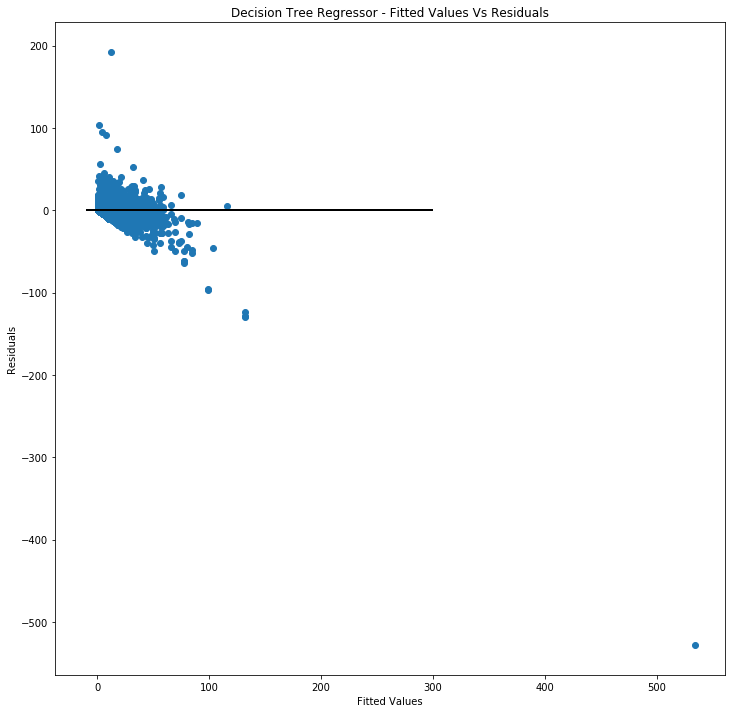

In [137]:
plt.scatter(y1_pred_test,residuals_dt_test)
plt.hlines(y=0, xmin=-10, xmax=300, color='black', lw=2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Decision Tree Regressor - Fitted Values Vs Residuals")
plt.show()

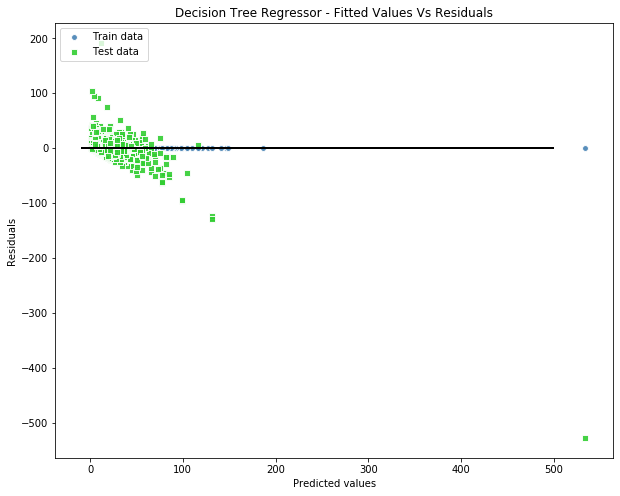

In [138]:

# plotting residuals to see the error pattern

plt.figure(figsize = (10,8))

plt.scatter(y1_pred_train,residuals_dt_train,
               c='steelblue',
                edgecolor='white',
                marker='o',
                s=35,
                alpha=0.9,
                label='Train data')


plt.scatter(y1_pred_test,residuals_dt_test,
                c='limegreen',
                edgecolor='white',
                marker='s',
                s=35,
                alpha=0.9,
                label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title("Decision Tree Regressor - Fitted Values Vs Residuals")
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=500, lw=2, color='black')
#plt.xlim([-10, 50])
plt.show()

In [ ]:
#Decision Tree Regressor Evaluation:
#As the errors are randomly distributed and do not see a pattern behind errors, decision tree algorithms seems to explain the variance in the model

In [139]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000,
                                    criterion='mse',
                                    random_state=1,
                                    n_jobs=-1)


rfmodel = forest.fit(X1_train, y1_train)

# Predicting a new result for test data 
y1_pred_train_rf = forest.predict(X1_train)


# Predicting a new result for test data 
y1_pred_test_rf = forest.predict(X1_test)

MemoryError: could not allocate 1835008 bytes